In [1]:
%matplotlib inline
# %matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import re

# TO DO
# 1) change from len(x) to x.shape[]
# 2) check if all t are correct after changing during work on task i
# 3) export time from lammps
# 4) loop over dataframes: change to enumerate

In [2]:
def read_dump(filename):
    """
    Stores data and sorts.
    """
    f_open = open(filename, 'r', newline='\n')
    data = f_open.read()
    f_open.close()

    no_atoms_str = 'ITEM: NUMBER OF ATOMS'
    no_atoms = int(data[data.find(no_atoms_str) +
                        len(no_atoms_str):data.find('ITEM: BOX')])

    str_itm_atm = 'ITEM: ATOMS'

    idx_itm_atm = data.find(str_itm_atm) + len(str_itm_atm) + 1
    idx_end_cols = data.find('\n', idx_itm_atm) - 1

    if '[' in data[idx_itm_atm: idx_end_cols]:
        # If Lammps dump file contains [] from printing an array, it must be
        # removed such that finditer can find proper indices. See below.
        data = data.replace('[', '')
        data = data.replace(']', '')
        idx_itm_atm = data.find(str_itm_atm) + len(str_itm_atm) + 1
        idx_end_cols = data.find('\n', idx_itm_atm) - 1

    # Column names of dataframe
    col_titles = data[idx_itm_atm: idx_end_cols].split(' ')

    dict_list = []

    # Creating dictionary with empty list as values
    data_dict = dict.fromkeys(col_titles, [])

    idx_end_num_data = [match.start()
                        for match in re.finditer('ITEM: TIMESTEP', data[1:])]
    idx_start_num_data = [match.end() + 2
                          for match in re.finditer(col_titles[-1], data)]
    idx_end_num_data.append(-1)  # Including end

    for k in range(len(idx_start_num_data)):
        num_data = data[idx_start_num_data[k]: idx_end_num_data[k]]
        lines = num_data.split('\n')

        for i in range(len(lines)):
            elms = lines[i].split(' ')

            data_dict = dict((j, elms[col_titles.index(j)])
                             for j in col_titles)
            dict_list.append(data_dict)

    dataframe = pd.DataFrame(dict_list, columns=col_titles, dtype=np.float)

    return dataframe

In [3]:
def read_log(name=False):
    if name:
        with open(name, 'r', newline='\n') as f_open:
            data = f_open.read().replace('\r', '')
    else:
        with open('log.lammps', 'r', newline='\n') as f_open:
            data = f_open.read().replace('\r', '')

    # data = data.split()

    idx_col_titles_start = [match.start()
                            for match in re.finditer('Step', data)]
    idx_end_num = [match.start() for match in re.finditer('Loop', data)]

    datasets = len(idx_col_titles_start)

    idx_col_titles_end = [
        data.find('\n', idx_col_titles_start[i]) for i in range(datasets)]

    col_titles = data[idx_col_titles_start[0]: idx_col_titles_end[0]].split()

    dataframe_list = []  # List of dataframe for all timesteps

    for k in range(datasets):
        dict_list = []  # List of dataframe for current timestep

        num_data = data[idx_col_titles_end[k] + 1: idx_end_num[k] - 1]
        num_data = re.sub(' +', ' ', num_data)

        lines = num_data.split('\n')

        for i in range(len(lines)):
            elms = lines[i].split()

            data_dict = dict((j, elms[col_titles.index(j)])
                             for j in col_titles)

            dict_list.append(data_dict)

        df = pd.DataFrame(dict_list, columns=col_titles, dtype=np.float)

        dataframe_list.append(df)

#     if len(dataframe_list) < 2:
#         return dataframe_list[0]
#     else:
    return dataframe_list

In [4]:
def f(v, T):
    return 4 * np.pi * v**2 * (1 / (2 * np.pi * T))**(3 / 2) * \
        np.exp(-v**2 / (2 * T))


def plot_histogram(v, v_arr, no_tsteps, no_atoms, no_bins, T=2.5):
    for i in range(0, no_tsteps, no_tsteps // 10):
        plt.hist(v_arr[i, :], bins=no_bins, density=True)
        plt.plot(v_arr[i, :], f(v_arr[i, :], T))
        plt.title(f'Time: {0.005 * i:.2f}')
        print(i)
        plt.show()

#     v = np.sort(v)

#     plt.hist(v, bins=no_bins, density=True)
#     plt.plot(v, f(v, T))
#     plt.show()
    
    
def histogram_time_evo(v, v_arr, no_bins):
    hist_list = []
    hist_last = np.histogram(v_arr[-1, :], bins=no_bins)[0]
    hist_last2 = np.sum(hist_last * hist_last)

    t_steps = len(v_arr[:, 0])

    for i in range(t_steps):
        h = np.histogram(v_arr[i, :], bins=no_bins)[0]
        hh = np.sum(h * hist_last)
        hist_list.append(hh / hist_last2)

    x = np.linspace(0, t_steps * 0.005, t_steps)

    plt.plot(x, hist_list, label='Hist. values')
    plt.plot(x, np.ones(t_steps), '--', label='Theoretical')
    plt.legend(loc='best')
    plt.xlabel('Time t')
    plt.ylabel('Histogram values')
    plt.show()

In [5]:
no_tsteps = 500
no_atoms = 4000

df = read_dump('./task_a/dump.task_a')

v = df[['vx', 'vy', 'vz']].to_numpy()
v = np.sqrt(v[:, 0] * v[:, 0] + v[:, 1] * v[:, 1] + v[:, 2] * v[:, 2])
T = df[['Temp']].to_numpy()[0]
print(T)

v_arr = np.zeros((no_tsteps, no_atoms))

for i in range(no_tsteps):
    v_arr[i, :] = np.sort(v[i * (no_atoms):(i + 1) * no_atoms])

plot_histogram(v, v_arr, no_tsteps, no_atoms, 50, T=1.25)


FileNotFoundError: [Errno 2] No such file or directory: './task_a/dump.task_a'

From the above we see that the distribution tends to a Boltzmann distribution. Below is the time development of the distribution of velocities.

In [6]:
histogram_time_evo(v, v_arr, 50)

NameError: name 'v' is not defined

By the central limit theorem we observe that the normalized inner product 

$\sum_i h_i(t)h_i(t_n)/\sum_i h_i(t)h_i(t) = 1$

if the velocity distribution follows a Boltzmann distribution $\forall$ t. We therefore expect the normalized inner product to be 1. We observe from the above time development that the velocity distribution quickly stabilizes around the expected value 1.

## Task b)

In [7]:
def energy(df):
    print(df.shape)
    if df.shape[1] > 2:
        for i in range(len(df)):
            # Each timestep
            dataframe = df[i]
            E = dataframe[['TotEng']].to_numpy()
            dt = dataframe[['Dt']].to_numpy(dtype=float)[0]
            t_steps = dataframe[['Step']].to_numpy(dtype=int)[-1]

            t = np.linspace(0, t_steps * dt, len(E))

            plt.plot(t, E[:, 0], label='dt=' + str(dt[0]))
            plt.xlabel('Time t [L-J]')
            plt.ylabel('Energy [L-J]')
            plt.legend()
            plt.show()
    else:
        E = df[['TotEng']].to_numpy()
        t_steps = df[['Step']].to_numpy(dtype=int)[-1]

        t = np.linspace(0, t_steps * 0.005, E.shape[0])

        plt.plot(t, E)
        plt.xlabel('Time t [L-J]')
        plt.ylabel('Energy [L-J]')
        plt.legend()
        plt.show()
    
energy(read_log())

IndexError: list index out of range

From the above figures we see that the energy dissiapates linearly (after a short time) for $dt=0.01$, while for other two cases with smaller $dt$ the energy quickly falls before stabilizing, as the atoms move from the initial distribution to a stable state.

## Task c)

In [8]:
def temperature_variable_box(df):
    for sys_size in range(len(df)):
        # Each timestep
        dataframe = df[sys_size]
        T = dataframe[['Temp']].to_numpy()
        dt = dataframe[['Dt']].to_numpy()[0]
        xhi = dataframe[['Xhi']].to_numpy(dtype=int)[0,0]
        t_steps = dataframe[['Step']].to_numpy(dtype=int)[0]

        equi_factor = 0.2

        t_start = int(t_steps * equi_factor)
        t_equi_steps = int(len(T) * (1 - equi_factor))
        t = np.linspace(t_start * dt, t_steps * dt, t_equi_steps)
        T = T[int(equi_factor * len(T)) + 1:]    # System i equilibrium

        T_avg = np.sum(T) / len(T)
        print(f'Average temperature: {T_avg:.3f} [L-J]')

        plt.plot(t, T)
        plt.xlabel('Time t')
        plt.ylabel('Temperature')
        plt.title(f'Box with xhi, yhi, zhi = {xhi}')
        plt.show()

temperature_variable_box(read_log())

IndexError: list index out of range

From the above plots we observe that the fluctuations in temperature stabilize as the system becomes larger. Since we are keeping the particle density constant, $0.01$ [L-J] varying the system size corresponds to varying the amount of atoms. 

## Task d)


In [9]:
def pressure(df):
    T = np.zeros(len(df))
    P = np.zeros_like(T)
    
    for temp in range(len(df)):
        # Looping over different temperatures
        dataframe = df[temp]
        P[temp] = np.average(dataframe[['Press']].to_numpy())
        T[temp] = dataframe[['Temp']].to_numpy()[0]

    plt.plot(T, P, '-o')
    plt.xlabel('Temperature [L-J]')
    plt.ylabel('Pressure [L-J]')
    plt.show()
    
pressure(read_log())

IndexError: list index out of range

From the figure above we see that the pressure increases linearly as we increase the temperature. Since we are keeping the system size, energy and number of particles constant we expect a linear depence on the temperature and pressure.

## Task e)

In [10]:
def density(df):
    no_temps = 8
    no_dens = no_temps
    
    P = np.zeros((no_temps, no_dens))
    T = np.zeros(no_temps)
    rho = np.zeros(no_dens)
    
    equi_factor = 0.3
    
    for i in range(no_temps):
        start = i * no_dens
        stop = (i + 1) * no_dens
        dataframe = df[start:stop]
                
        for j in range(no_dens):
            dataframe_slice = dataframe[j]
            T[i] = dataframe_slice[['Temp']].to_numpy()[0, 0]
            rho[j] = dataframe_slice[['Density']].to_numpy()[j, 0]
            P[i, j] = np.average(dataframe_slice[['Press']].to_numpy()[int(j * equi_factor):, 0])
            
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    T, rho = np.meshgrid(T, rho)
    ax.plot_surface(T, rho, P)
    ax.set_xlabel('Temperature [L-J]')
    ax.set_ylabel('Density [L-J]')
    ax.set_zlabel('Pressure [L-J]')
    plt.show()
    
density(read_log())

IndexError: list index out of range

In the above figure we see that the pressure increases as both the temperature and density increases. The average pressure is given by

\begin{equation}
P = \rho k_B T + \frac{3}{2}\sum_{i < j} \mathbf{F}_{ij} \cdot \mathbf{r}_{ij},
\end{equation}

which tells us we would expect a linear dependence on the pressure, temperature and density. 

## Task f)

/home/christer/anaconda3/envs/my-lammps-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


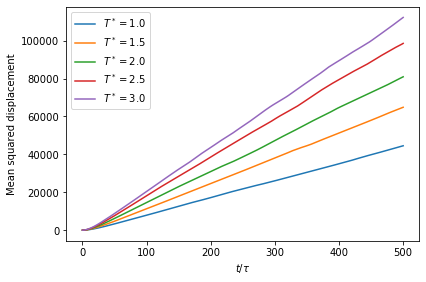

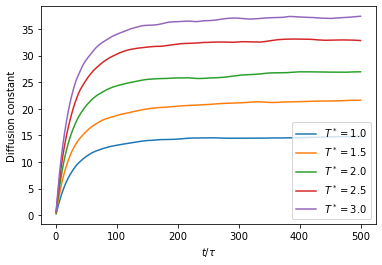

Diffusion constants: [14.84 21.61 26.97 32.84 37.41], for temperatures [1.0, 1.5, 2.0, 2.5, 3.0]


In [53]:
def displacement(df):
    D = []
    msd = []
    T = []

    t = df[0][['Time']].to_numpy()

    for i, dataframe in enumerate(df):
#         dataframe = df[temp]
        T.append(dataframe[['Temp']].to_numpy()[0, 0])
        msd.append(dataframe[['c_myMSD[4]']].to_numpy()[:, 0])
        D.append(msd[i] / (6 * t[:, 0]))
    
    return D, msd, T, t

D, msd, T, t = displacement(read_log('./task_f/log.lammps'))

for i in range(len(D)):
    plt.plot(t, msd[i])
    plt.xlabel(f'$t / \\tau$')
    plt.ylabel('Mean squared displacement')
plt.legend([f'$T^* = {temp}$' for temp in T])
plt.tight_layout(True)
plt.show()

for i in range(len(D)):
    plt.plot(t, D[i])
    plt.xlabel(f'$t / \\tau$')
    plt.ylabel('Diffusion constant')
plt.legend([f'$T^*={temp}$' for temp in T])
plt.show()

D_vals = [D[i][-1] for i in range(len(D))]
D_vals = np.around(D_vals, decimals=2)
print(f'Diffusion constants: {D_vals}, for temperatures {T}')
    


We see that the diffusion constant and the mean squared displacement increases with temperature. A larger diffusion constant means the gas diffuses faster, as we can see by the unit of the diffusion constant (in SI) $m^2/s$, which we can also see by the mean squared displacement.

## Task g)

By reducing the initial temperature to $10^{-8}$ [L-J] we can simulate a solid for 20000 timesteps. Increasing the temperature slightly ($>10^{-7}$) yields a phase transition to gas during the time evolution.

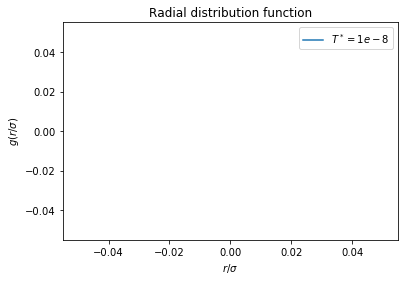

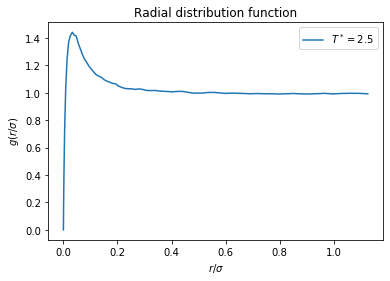

In [54]:
def rdf(filename):
    with open(filename, 'r', newline='\n') as f_open:
        data = f_open.read()

    data = re.sub(' +', ' ', data)

    lines = data.split('\n')
    lines = lines[4:-1]
        
    rdf_arr = np.zeros((len(lines), 2))

    for i, line in enumerate(lines):
        temp = np.fromstring(line, dtype=float, sep=' ')
       
        rdf_arr[i, :] = temp[2:]

    r = rdf_arr[:, 1]
    g = rdf_arr[:, 0]
    
    return r, g

r, g = rdf('./task_g/time_avg_rdf_T1e-8.txt')
r_2, g_2 = rdf('./task_g/time_avg_rdf_T2.5.txt')

plt.plot(r, g, label=f'$T^*= 1e-8$')
plt.xlabel('$r / \\sigma$')
plt.ylabel('$g(r/\\sigma)$')
plt.title('Radial distribution function')
plt.legend()
plt.show()

plt.plot(r_2, g_2, label=f'$T^* = 2.5$')
plt.xlabel('$r / \\sigma$')
plt.ylabel('$g(r/\\sigma)$')
plt.title('Radial distribution function')
plt.legend()
plt.show()

Text regarding previous task

## Task h)
Berendsen thermostat


## Task i)

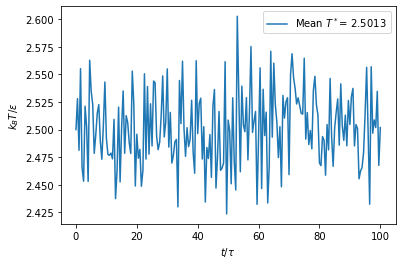

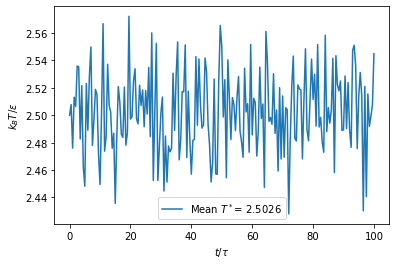

/home/christer/anaconda3/envs/my-lammps-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


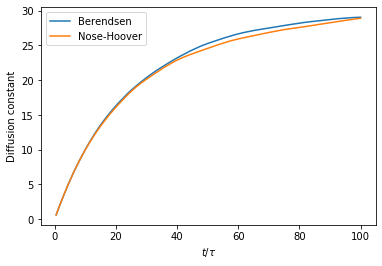

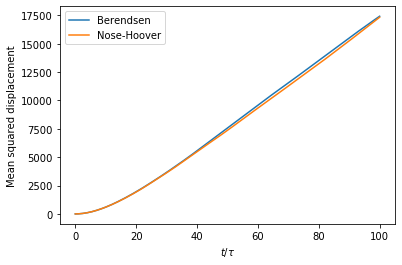

In [59]:
def temperature_thermostat(df):
    for i, dataframe in enumerate(df):
        T = dataframe[['Temp']].to_numpy()
        t = dataframe[['Time']].to_numpy()
    
    plt.plot(t, T)
    plt.xlabel('$t/\\tau$')
    plt.ylabel('$k_B T / \epsilon$')
    plt.legend([f'Mean $T^*$= {np.average(T):.4f}'])
    plt.show()
    

temperature_thermostat(read_log('./task_i/log.berendsen'))
temperature_thermostat(read_log('./task_i/log.nose-hoover'))

r, g = rdf('./task_i/time_avg_rdf_berendsen.txt')
r_2, g_2 = rdf('./task_i/time_avg_rdf_nose-hoover.txt')


D_b, msd_b, T_b, t_b = displacement(read_log('./task_i/log.berendsen'))
D, msd, T, t = displacement(read_log('./task_i/log.nose-hoover'))

plt.plot(t_b, D_b[0], label=f'Berendsen')
plt.plot(t, D[0], label=f'Nose-Hoover')
plt.xlabel('$t/\\tau$')
plt.ylabel('Diffusion constant')
plt.legend()
plt.show()

plt.plot(t_b, msd_b[0], label=f'Berendsen')
plt.plot(t, msd[0], label=f'Nose-Hoover')
plt.xlabel('$t/\\tau$')
plt.ylabel('Mean squared displacement')
plt.legend()
plt.show()


Text about above

## Task j)

Stillinger-Weber potential:

\begin{equation*}
E = \sum_i \sum_j V_2(r_{ij}) + \sum_i \sum_j \sum_k V_3(r_{ij}, r_{ik}, \theta_{ijk}),
\end{equation*}

where 

\begin{equation*}
V_2(r_{ij} = A_{ij}\epsilon_{ij}\left[B_{ij}\left(\frac{\sigma_{ij}}{r_{ij}}\right)^{p_{ij}} - \left(\frac{\sigma_{ij}}{r_{ij}}\right)^{q_{ij}}\right] \exp\left(\frac{\sigma_{ij}}{r_{ij} - a_{ij}\sigma_{ij}}\right)
\end{equation*}

and

\begin{equation*}
V_3(r_{ij}, r_{ik}, \theta_{ijk}) = \lambda_{ijk}\epsilon_{ijk}\left[\cos\theta_{ijk} - \cos\theta_{ijk,0}\right]^2 \exp\left(\frac{\gamma_{ij}\sigma_{ij}}{r_{ij} - a_{ij}\sigma_{ij}}\right)\exp\left(\frac{\gamma_{ik}\sigma_{ik}}{r_{ij} - a_{ik}\sigma_{ik}}\right).
\end{equation*}

We observe that $V_2$ is similar to Lennard-Jones potential, 

\begin{equation*}
U(r) = 4\epsilon\left(\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6\right),
\end{equation*}

where the terms in the square brackets of $V_2$ and $U(r)$ both handle pairwise interactions, but they differ in exponenent of both terms. There is an added weight $B_{ij}$ of the first term in $V_2$, which scales the attraction between particles. $V_3$ handles the interaction between three particles, considering the angle between them as well as the distance, considering this for a two-particle interaction would cause the term to be zero, as the cosine part would be 0.

## Task k)